In [1]:
import numpy as np 
import pandas as pd 
from pylab import rcParams
import matplotlib.pyplot as plt
import warnings
import itertools
import statsmodels.api as sm
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.metrics import mean_squared_error
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import math
from sklearn.preprocessing import MinMaxScaler
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
from keras.utils import plot_model

Using TensorFlow backend.


In [2]:
pd.read_csv("BrentOilPrices.csv").head()

,Date,Price
0,"May 20, 1987",18.63
1,"May 21, 1987",18.45
2,"May 22, 1987",18.55
3,"May 25, 1987",18.60
4,"May 26, 1987",18.63


In [3]:
dateparse = lambda x: pd.datetime.strptime(x, '%b %d, %Y')

In [4]:
df = pd.read_csv("BrentOilPrices.csv", parse_dates=['Date'], date_parser=dateparse)

In [5]:
df = df.sort_values('Date')

In [6]:
df.set_index('Date', inplace=True)

In [7]:
df.index

DatetimeIndex(['1987-05-20', '1987-05-21', '1987-05-22', '1987-05-25',
               '1987-05-26', '1987-05-27', '1987-05-28', '1987-05-29',
               '1987-06-01', '1987-06-02',
               ...
               '2019-09-17', '2019-09-18', '2019-09-19', '2019-09-20',
               '2019-09-23', '2019-09-24', '2019-09-25', '2019-09-26',
               '2019-09-27', '2019-09-30'],
              dtype='datetime64[ns]', name='Date', length=8216, freq=None)

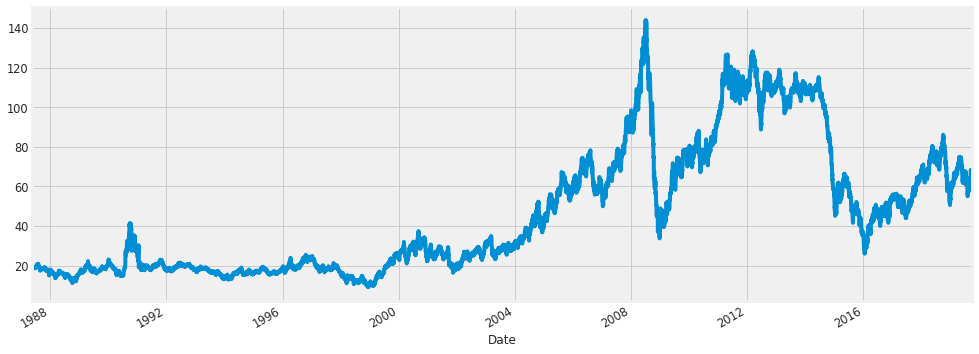

In [8]:
df['Price'].plot(figsize=(15, 6))
plt.show()

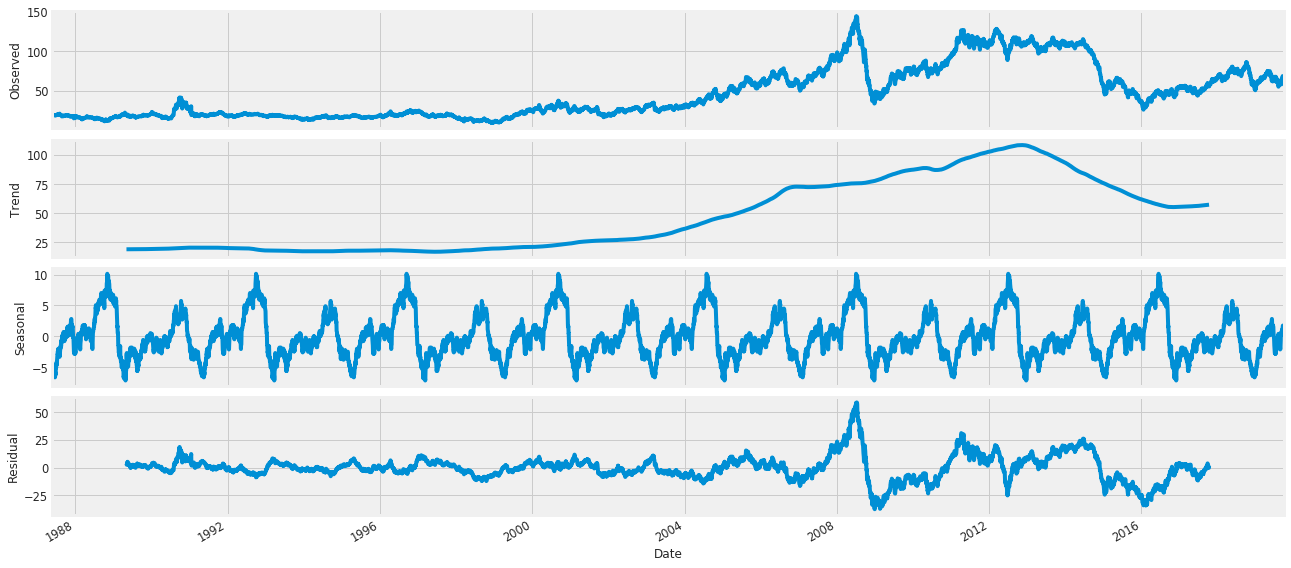

In [9]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(df["Price"], model='additive', freq=1000)
fig = decomposition.plot()
plt.show()

In [10]:
sc = MinMaxScaler(feature_range = (0, 1))
scaled_Array = sc.fit_transform(df)

In [11]:
df["Scaled Price"] = scaled_Array

In [12]:
df.head()

,Price,Scaled Price
Date,,
1987-05-20,18.63,0.070671
1987-05-21,18.45,0.069336
1987-05-22,18.55,0.070078
1987-05-25,18.60,0.070449
1987-05-26,18.63,0.070671


In [13]:
train_size = int(len(df) * 0.70)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size, 1:2], df.iloc[train_size:len(df), 1:2]

In [14]:
def create_data_set(_data_set, _look_back=1):
    data_x, data_y = [], []
    for i in range(len(_data_set) - _look_back - 1):
        a = _data_set.iloc[i:(i + _look_back), 0]
        data_x.append(a)
        data_y.append(_data_set.iloc[i + _look_back, 0])
    return np.array(data_x), np.array(data_y)

In [15]:
look_back = 60
X_train,Y_train,X_test,Ytest = [],[],[],[]
X_train,Y_train=create_data_set(train,look_back)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test,Y_test=create_data_set(test,look_back)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [16]:
Y_train

array([0.07638116, 0.07526882, 0.07230256, ..., 0.50048202, 0.50092696,
       0.50812013])

In [17]:
regressor = Sequential()

regressor.add(LSTM(units = 60, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 60, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 60, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 60))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
reduce_lr = ReduceLROnPlateau(monitor='val_loss',patience=5)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



In [18]:
plot_model(regressor, to_file='model.png')

In [19]:
history =regressor.fit(X_train, Y_train, epochs = 25, batch_size = 64,validation_data=(X_test, Y_test), callbacks=[reduce_lr])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 5690 samples, validate on 2404 samples
Epoch 1/25
5690/5690 [==============================] - 69s 12ms/step - loss: 0.0052 - val_loss: 0.0032
Epoch 2/25
5690/5690 [==============================] - 29s 5ms/step - loss: 0.0011 - val_loss: 0.0035
Epoch 3/25
5690/5690 [==============================] - 25s 4ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 4/25
5690/5690 [==============================] - 25s 4ms/step - loss: 8.6240e-04 - val_loss: 7.8663e-04
Epoch 5/25
5690/5690 [==============================] - 25s 4ms/step - loss: 7.6044e-04 - val_loss: 0.0010
Epoch 6/25
5690/5690 [==============================] - 24s 4ms/step - loss: 7.2865e-04 - val_loss: 0.0017
Epoch 7/25
5690/5690 [==============================] - 24s 4ms/step - loss: 7.6651e-04 - val_loss: 0.0019
Epoch 8/25
5690/5690 [==============================] - 25s 4ms/step - loss: 7.6468e-04 - val_loss: 6.6758e-04
Epoc

In [20]:
train_predict = regressor.predict(X_train)
test_predict = regressor.predict(X_test)

In [21]:
train_predict = sc.inverse_transform(train_predict)
Y_train = sc.inverse_transform([Y_train])
test_predict = sc.inverse_transform(test_predict)
Y_test = sc.inverse_transform([Y_test])

In [22]:
Y_test = Y_test.reshape(Y_test.shape[1],Y_test.shape[0])
Y_train = Y_train.reshape(Y_train.shape[1],Y_train.shape[0])

Train Mean Absolute Error: 1.1962655198913466
Train Root Mean Squared Error: 1.9164871479339118
Test Mean Absolute Error: 2.215981231537119
Test Root Mean Squared Error: 2.823476892225809


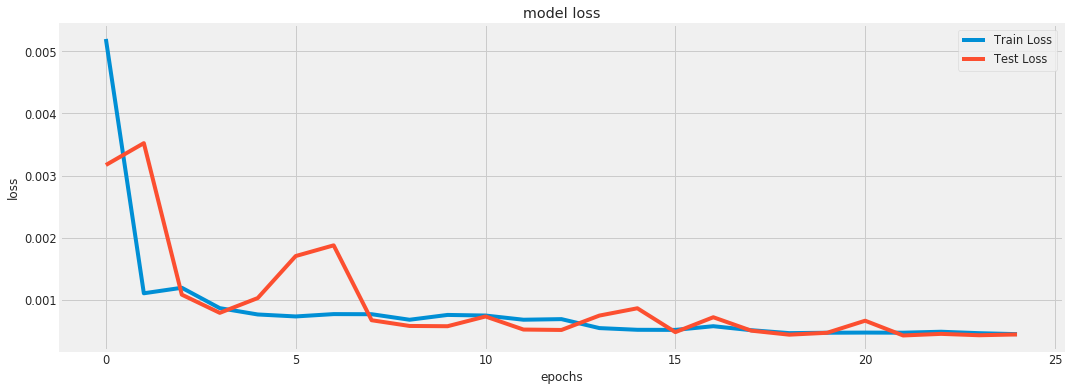

In [23]:
print('Train Mean Absolute Error:', mean_absolute_error(Y_train, train_predict))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train, train_predict)))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test, test_predict))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test, test_predict)))

plt.figure(figsize=(16,6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

In [24]:
(np.diff(Y_train, axis=0) - np.diff(train_predict, axis=0)) / np.diff(Y_train, axis=0)

array([[ 0.27705129],
       [ 0.70945835],
       [-0.2547493 ],
       ...,
       [ 0.80106354],
       [-7.63812764],
       [ 0.26037346]])

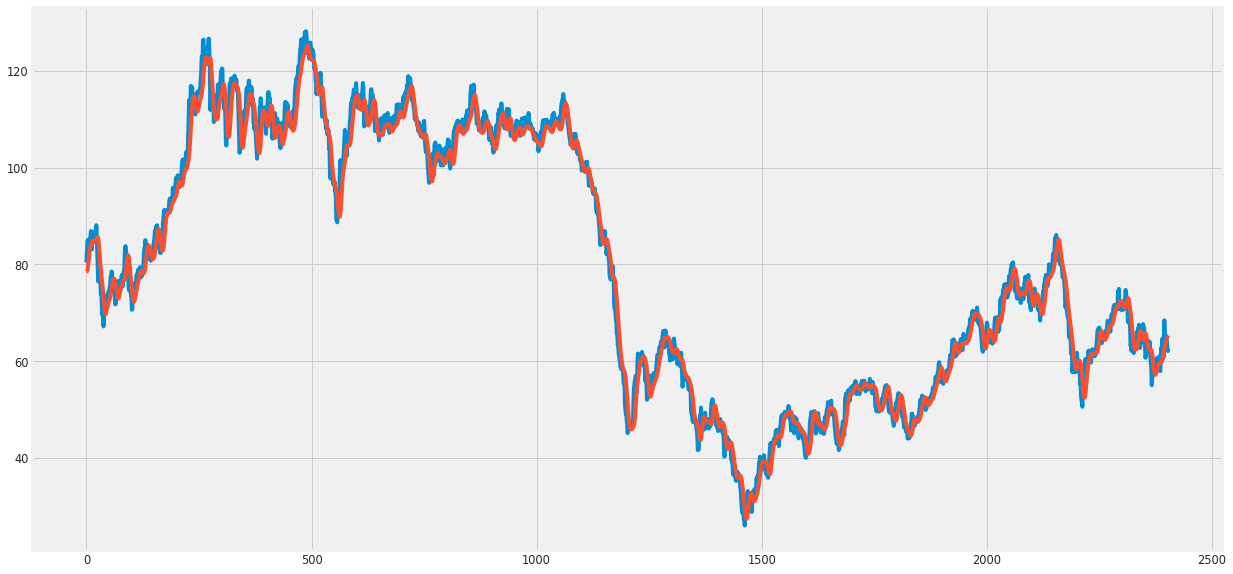

In [28]:
plt.figure(figsize=(19,10))
plt.plot(Y_test, label="actual test")
plt.plot(test_predict, label="prediction test")
# plt.plot(Y_train, label="actual train")
# plt.plot(train_predict, label="prediction train")
plt.show();